**Predict Housing Prices**

*Step 1: Import Libraries*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score 
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression, ElasticNet, Lasso, Ridge, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR

*Step 2: Load and Display Data*

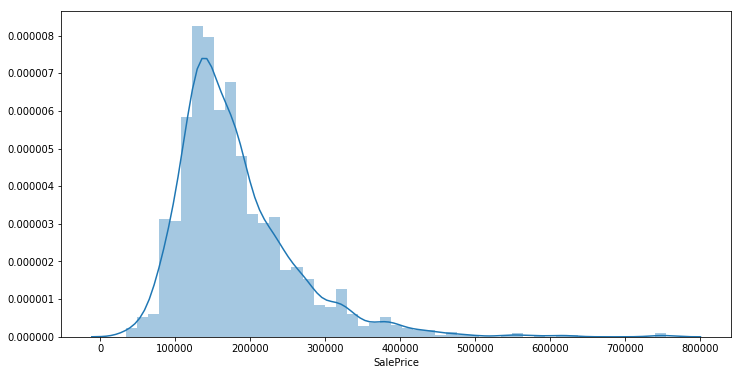

In [2]:
hpart_file_path = '../input/train.csv'
hpart_data = pd.read_csv(hpart_file_path) 
y = hpart_data.SalePrice
all_features = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition','Id','SalePrice']
X=hpart_data[all_features]
plt.figure(figsize=(12, 6))
_ = sns.distplot(y)

*Step 3: Preprocess Data*

In [3]:
train_data=X
target=y
test_data = pd.read_csv('../input/test.csv')                            
candidate_train_predictors = train_data.drop(['Id', 'SalePrice'], axis=1)
candidate_test_predictors = test_data.drop(['Id'], axis=1)
low_cardinality_cols = [cname for cname in candidate_train_predictors.columns if 
                                candidate_train_predictors[cname].nunique() < 10 and
                                candidate_train_predictors[cname].dtype == "object"]
numeric_cols = [cname for cname in candidate_train_predictors.columns if 
                                candidate_train_predictors[cname].dtype in ['int64', 'float64']]
my_cols = low_cardinality_cols + numeric_cols
train_predictors = candidate_train_predictors[my_cols]
test_predictors = candidate_test_predictors[my_cols]
one_hot_encoded_training_predictors = pd.get_dummies(train_predictors)
one_hot_encoded_test_predictors = pd.get_dummies(test_predictors)
final_train, final_test = one_hot_encoded_training_predictors.align(one_hot_encoded_test_predictors,join='left',axis=1)
train_data=final_train
test_data=final_test
my_imputer = Imputer(axis=1)
imputed_train_data = my_imputer.fit_transform(train_data)
imputed_test_data = my_imputer.fit_transform(test_data)
imputed_train_data=pd.DataFrame(imputed_train_data)
imputed_test_data=pd.DataFrame(imputed_test_data)
final_train=imputed_train_data
final_test=imputed_test_data
X2 = final_train
y = target
train_X, test_X, train_y, test_y = train_test_split(X2, y,random_state = 0)

*Step 4: Evaluate Regressors*

In [4]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(train_X, train_y, early_stopping_rounds=5, 
             eval_set=[(test_X, test_y)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [5]:
predictions = my_model.predict(test_X)
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 16408.8728917


In [6]:
test = pd.read_csv('../input/test.csv')
test_X2 = final_test
predicted_prices = my_model.predict(test_X2)
my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': predicted_prices})
my_submission.to_csv('Submission_A.csv', index=False)

*Step 5: Evaluate Regressors Using Cross Validation*

In [7]:
X2 = final_train
y = target

In [8]:
my_pipeline = make_pipeline(Imputer(), XGBRegressor(n_estimators=1000, learning_rate=0.05))
my_pipeline.fit(X2, y)
scores = cross_val_score(my_pipeline, X2, y, scoring='neg_mean_absolute_error')
print(scores)

[-14972.60175501 -16727.19747016 -16591.67266268]


In [9]:
# test = pd.read_csv('../input/test.csv')
test_X2 = final_test
predicted_prices = my_pipeline.predict(test_X2)
my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': predicted_prices})
my_submission.to_csv('Submission_B.csv', index=False)

*Step 6: Feature Selection*

In [10]:
selected_features =  ['MSZoning','Street','Utilities', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'TotalBsmtSF', 'CentralAir', '1stFlrSF', '2ndFlrSF',
       'TotRmsAbvGrd', 'Fireplaces','GarageType','GarageCars', 'PavedDrive', 'WoodDeckSF',
       'EnclosedPorch', 'YrSold','BsmtFinSF1','FullBath',
       'SaleCondition']
selected_features =  ['YearBuilt', 'YearRemodAdd', 'TotalBsmtSF','1stFlrSF', '2ndFlrSF',
       'TotRmsAbvGrd', 'Fireplaces','GarageCars']
train_predictors_small=train_predictors[selected_features]
test_predictors_small=test_predictors[selected_features]
one_hot_encoded_training_predictors2 = pd.get_dummies(train_predictors_small)
one_hot_encoded_test_predictors2 = pd.get_dummies(test_predictors_small)
final_train2, final_test2 = one_hot_encoded_training_predictors2.align(one_hot_encoded_test_predictors2,join='left',axis=1)
train_data2=final_train2
test_data2=final_test2
my_imputer = Imputer(axis=1)
imputed_train_data2 = my_imputer.fit_transform(train_data2)
imputed_test_data2 = my_imputer.fit_transform(test_data2)
imputed_train_data2=pd.DataFrame(imputed_train_data2)
imputed_test_data2=pd.DataFrame(imputed_test_data2)
final_train2=imputed_train_data2
final_test2=imputed_test_data2
X3 = final_train2
y = target

*Step 7: Evaluate Regressors After Feature Selection*

In [11]:
my_pipeline = make_pipeline(Imputer(), XGBRegressor(n_estimators=1000, learning_rate=0.05))
my_pipeline.fit(X3, y)
scores = cross_val_score(my_pipeline, X3, y, scoring='neg_mean_absolute_error')
print(scores)

[-21948.01524801 -20775.9320497  -21337.09360532]


In [12]:
# test = pd.read_csv('../input/test.csv')
test_X3 = final_test2
predicted_prices = my_pipeline.predict(test_X3)
my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': predicted_prices})
my_submission.to_csv('Submission_C.csv', index=False)

*Step 8: Try Another Method (PCA) for Feature Selection*

In [13]:
X4 = final_train
xValuesScaled = preprocessing.scale(X4)
xValuesScaled = pd.DataFrame(xValuesScaled)
yValues = target
X5 = final_test
xValuesScaledTest = preprocessing.scale(X5)
xValuesScaledTest = pd.DataFrame(xValuesScaledTest)
yValues = target
variance_pct = .9999 # Minimum percentage of variance we want to be described by the resulting transformed components
pca = PCA(n_components=variance_pct) # Create PCA object
X_transformed = pca.fit_transform(xValuesScaled,yValues) # Transform the initial features
xValuesScaledPCA = pd.DataFrame(X_transformed) # Create a data frame from the PCA'd data
X_transformedTest = pca.transform(xValuesScaledTest,) 
xValuesScaledPCATest = pd.DataFrame(X_transformedTest) 


Feature Correlation Before PCA:



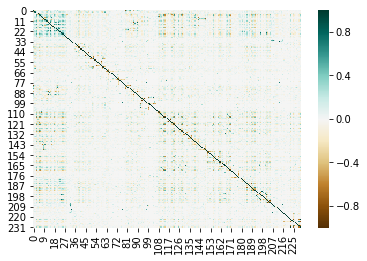

In [14]:
print("\nFeature Correlation Before PCA:\n")
g = sns.heatmap(xValuesScaled.corr(),cmap="BrBG",annot=False)


Feature Correlation After PCA:



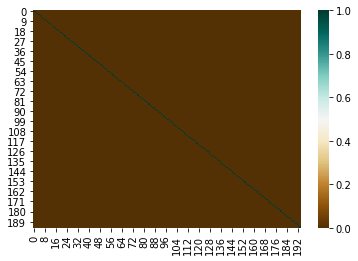

In [15]:
print("\nFeature Correlation After PCA:\n")
g = sns.heatmap(xValuesScaledPCA.corr(),cmap="BrBG",annot=False)

*Step 9: Evaluate Regressors After Feature Selection*

In [16]:
my_pipeline = make_pipeline(Imputer(), XGBRegressor(n_estimators=1000, learning_rate=0.05))
my_pipeline.fit(xValuesScaledPCA, yValues)
scores = cross_val_score(my_pipeline, xValuesScaledPCA, yValues, scoring='neg_mean_absolute_error')
print(scores)

[-17804.05396561 -19057.43421137 -17788.25541731]


In [17]:
# test = pd.read_csv('../input/test.csv')
test_X3 = xValuesScaledPCATest
predicted_prices = my_pipeline.predict(test_X3)
my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': predicted_prices})
my_submission.to_csv('Submission_D.csv', index=False)

*Step 10: Evaluate Additional Regressors*

In [18]:
X_trainScaled, X_testScaled, Y_trainScaled, Y_testScaled = train_test_split(xValuesScaled, yValues, test_size=0.2)
X_trainScaledPCA, X_testScaledPCA, Y_trainScaledPCA, Y_testScaledPCA = train_test_split(xValuesScaledPCA, yValues, test_size=0.2)

After Data Scaling:

Compare Multiple Classifiers: 

neg_mean_absolute_error Score: 

XGB: -17290.809578 (2130.095403)
ADA: -25310.845925 (1980.552352)
BR: -18395.750556 (1930.886012)
DTR: -26779.463771 (3138.277805)
EN: -18010.770142 (2318.279108)
GBR: -17074.517342 (1848.266145)
KNR: -26029.127303 (2773.198711)
RFR: -19618.103439 (2907.881651)
Ridge: -19462.837379 (1879.814852)


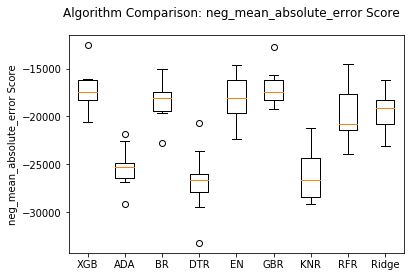

After PCA:

Compare Multiple Classifiers: 

neg_mean_absolute_error Score: 

XGB: -19032.918404 (2062.267834)
ADA: -27579.705806 (2261.469677)
BR: -18497.431440 (2127.082243)
DTR: -30343.946854 (3695.104702)
EN: -18098.700149 (1906.457049)
GBR: -19164.191327 (2322.179231)
KNR: -26438.136214 (2036.309122)
RFR: -21744.699104 (2397.732504)
Ridge: -19604.362783 (2904.951822)


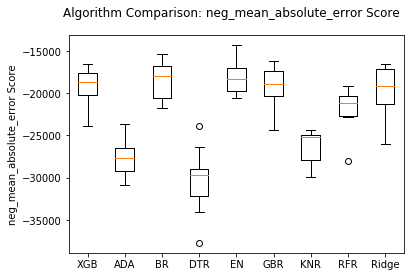


ADA = AdaBoostRegressor
BR = BayesianRidge
DTR = DecisionTreeRegressor
EN = ElasticNet
GBR = GradientBoostingRegressor
KNR = KNeighborsRegressor
RFR = RandomForestRegressor
LSCVR = LinearSVR
R = Ridge
XGB = XGBRegressor


In [19]:
def compareABunchOfRegressors(a, b, c, d):
    """
    compare performance of classifiers on X_train, X_test, Y_train, Y_test
    http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score
    http://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score
    """    
    print('\nCompare Multiple Classifiers: \n')
    print('neg_mean_absolute_error Score: \n')
    names = []
    models = []
    resultsAccuracy = []
    models.append(('XGB', XGBRegressor()))
    models.append(('ADA', AdaBoostRegressor()))
    models.append(('BR', BayesianRidge()))
    models.append(('DTR', DecisionTreeRegressor()))
    models.append(('EN', ElasticNet()))
    models.append(('GBR', GradientBoostingRegressor()))
    models.append(('KNR', KNeighborsRegressor()))
    #models.append(('L', Lasso()))
    #models.append(('LR', LinearRegression()))
    #models.append(('LSVR', LinearSVR()))
    models.append(('RFR', RandomForestRegressor()))
    models.append(('Ridge', Ridge()))
    #models.append(('SGD', SGDRegressor()))
    for name, model in models:
        model.fit(a, b)
        kfold = model_selection.KFold(n_splits=10, random_state=7)
        accuracy_results = model_selection.cross_val_score(model, a,b, cv=kfold, scoring='neg_mean_absolute_error')
        resultsAccuracy.append(accuracy_results)
        names.append(name)
        accuracyMessage = "%s: %f (%f)" % (name, accuracy_results.mean(), accuracy_results.std())
        print(accuracyMessage) 
    # Boxplot
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison: neg_mean_absolute_error Score')
    ax = fig.add_subplot(111)
    plt.boxplot(resultsAccuracy)
    ax.set_xticklabels(names)
    ax.set_ylabel('neg_mean_absolute_error Score')
    plt.show()

print("After Data Scaling:")
compareABunchOfRegressors(X_trainScaled, Y_trainScaled, X_testScaled, Y_testScaled)
print("After PCA:")
compareABunchOfRegressors(X_trainScaledPCA, Y_trainScaledPCA, X_testScaledPCA, Y_testScaledPCA)

def defineModels2():
    """
    This function just defines each abbreviation used in the previous function (e.g. LR = Logistic Regression)
    """
    print('\nADA = AdaBoostRegressor')
    print('BR = BayesianRidge')
    print('DTR = DecisionTreeRegressor')
    print('EN = ElasticNet')
    print('GBR = GradientBoostingRegressor')
    print('KNR = KNeighborsRegressor')
    #print('L = Lasso')
    #print('LR = LinearRegression \n\n')
    #print('LSCVR = LinearSVR')
    print('RFR = RandomForestRegressor')
    print('LSCVR = LinearSVR')
    print('R = Ridge')
    #print('SGD = SGDRegressor')
    print('XGB = XGBRegressor')
defineModels2()

*Step 11: Decide on Final Model*

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

clf = XGBRegressor(
    eval_metric = 'rmse',
    nthread = 4,
    eta = 0.1,
    num_boost_round = 80,
    max_depth = 5,
    subsample = 0.5,
    colsample_bytree = 1.0,
    silent = 1,
    )
parameters = {
    'num_boost_round': [5, 10, 50],
    'eta': [0.05, 0.1, 0.3],
    'max_depth': [3, 10, 15],
    'subsample': [0.9, 1.0],
    'colsample_bytree': [0.9, 1.0],
}

clf2 = RandomizedSearchCV(clf, parameters, n_jobs=1, cv=5)
clf2.fit(X_trainScaled, Y_trainScaled)
print("Optimized XGBoost Parameters:",clf2)
print('\nAccuracy of Optimized XGBoost Regressor on training data: {:.2f}'.format(clf2.score(X_trainScaled, Y_trainScaled)))
print('Accuracy of Optimized XGBoost Regressor on testing data: {:.2f}'.format(clf2.score(X_testScaled, Y_testScaled)))

Optimized XGBoost Parameters: RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, eta=0.1, eval_metric='rmse', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=4, num_boost_round=80, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=1, subsample=0.5),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'num_boost_round': [5, 10, 50], 'eta': [0.05, 0.1, 0.3], 'max_depth': [3, 10, 15], 'subsample': [0.9, 1.0], 'colsample_bytree': [0.9, 1.0]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

Accuracy of Optimized XGBoost Regressor on training data: 0.96
Accuracy of Optimized XGBoost Regressor on te

In [21]:
clf = XGBRegressor(n_estimators=500, learning_rate=0.1, scoring='neg_mean_absolute_error',early_stopping_rounds=5,max_depth=5,min_child_weight=200)
clf.fit(X_trainScaled, Y_trainScaled)
print('Accuracy of XGBoost Regressor on training data: {:.2f}'.format(clf.score(X_trainScaled, Y_trainScaled)))
print('Accuracy of XGBoost Regressor Classifier on testing data: {:.2f}'.format(clf.score(X_testScaled, Y_testScaled)))

Accuracy of XGBoost Regressor on training data: 0.91
Accuracy of XGBoost Regressor Classifier on testing data: 0.79


Credit: Many functions are adapted from [Kaggle Learn: Machine Learning](https://www.kaggle.com/learn/machine-learning).